# Tutorial

<a target="_blank" href="https://colab.research.google.com/github/andrrizzi/tfep/tree/tutorial-docs/docs/intro_to_MTFEP.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In this notebook we will perform a multimap targeted free energy perturbation (TFEP) on a toy system using the `tfep` library and compare its performance with standard free energy perturbation.

To run this you need to install the `tfep` library first together with the OpenMM optional package (see the [installation guide](https://tfep.readthedocs.io/en/latest/installation.html)). On Google Colab, the following cell will install the packages.

In [ ]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
    try:
        import tfep
    except ModuleNotFoundError:
        !pip install git+https://github.com/andrrizzi/tfep.git
        !pip install openmm

In [ ]:
# -------------- #
# Global imports #
# -------------- #
import functools
import os

import lightning
from matplotlib import pyplot as plt
import numpy as np
import MDAnalysis
import openmm
import pint
import seaborn as sns
import torch

import tfep.analysis

In [2]:
# -------------------- #
# Global configuration #
# -------------------- #

# TODO: what is the default context?
sns.set_context('notebook')

# Create the subfolder where to save all the generated data.
MAIN_DIR = 'tfep-tutorial'
os.makedirs(MAIN_DIR, exist_ok=True)

# Create a registry for unit and define the thermodynamic constants.
UNITS = pint.UnitRegistry()
TEMPERATURE = 298.15 * UNITS.kelvin  # Temperature of the system.
RT = (TEMPERATURE*UNITS.molar_gas_constant).to(UNITS.kJ/UNITS.mol).magnitude  # RT in units of kJ/mol

## MD simulation of a triatomic molecule

To perform a TFEP calculation we need samples from the perturbed state. We will consider a toy triatomic molecule in vacuum modeled using two harmonic bonds and a harmonic angle (think ozone) but no nonbonded interactions. We will collect samples for this system by running molecular dynamics using OpenMM.

In [4]:
def create_triatomic_molecule(
    r0=1.278*openmm.unit.angstroms,  # equilibrium bond length.
    K_r0=290.1*openmm.unit.kilocalories_per_mole/openmm.unit.angstrom**2,  # bond harmonic constant.
    alpha0=2.038*openmm.unit.radian,  # equilibrium angle.
    K_alpha0=900.0*openmm.unit.kilocalories_per_mole/openmm.unit.radian**2,  # angle harmonic constant.
    mass=15.999*openmm.unit.amu,  # atoms mass.
):
    """Create a triatomic molecule OpenMM System object.

    Parameters
    ----------
    r0 : openmm.unit.Quantity
        The equilibrium bond length betwen atoms.
    K_r0 : openmm.unit.Quantity
        The force constant for the harmonic bond.
    alpha0 : openmm.unit.Quantity
        The equilibrium angle between atoms 0-1-2.
    K_alpha0 : openmm.unit.Quantity
        The force constant for the harmonic angle.
    mass : openmm.unit.Quantity
        The mass of the three atoms.

    Returns
    -------
    system : openmm.System
        The OpenMM System object to simulate.
    topology : openmm.app.Topology
        The OpenMM Topology object.
    starting_positions : openmm.unit.Quantity
        The starting positions for the simulations (the equilibrium
        configuration).

    """
    from openmm.app import Topology, Element

    # Create an empty system object.
    system = openmm.System()

    # Add three particles to the system.
    n_atoms = 3
    for i in range(n_atoms):
        system.addParticle(mass)

    # Add a harmonic bond between atoms 0-1 and 1-2.
    force = openmm.HarmonicBondForce()
    force.addBond(0, 1, r0, K_r0)
    force.addBond(1, 2, r0, K_r0)
    system.addForce(force)

    # Add a harmonic angle between atoms 0-1-2.
    force = openmm.HarmonicAngleForce()
    force.addAngle(0, 1, 2, alpha0, K_alpha0)
    system.addForce(force)

    # Set the initial positions for a molecule in equilibrium.
    starting_positions = np.zeros([n_atoms, 3]) * openmm.unit.angstroms
    starting_positions[0, 0] = r0
    starting_positions[2, :2] = np.array([np.cos(alpha0._value), np.sin(alpha0._value)]) * r0

    # Create topology.
    topology = Topology()
    element = Element.getBySymbol('O')
    chain = topology.addChain()
    residue = topology.addResidue('O3', chain)
    atom0 = topology.addAtom('O', element, residue)
    atom1 = topology.addAtom('O', element, residue)
    atom2 = topology.addAtom('O', element, residue)
    topology.addBond(atom0, atom1)
    topology.addBond(atom1, atom2)

    return system, topology, starting_positions


def run_md():
    """Run an MD simulation of the toy system.

    This runs Langevin dynamics at temperature `TEMPERATURE` for 1ns using
    a timestep of 2fs and saving energies and configurations every 100fs.

    The results are saved in:
    - MAIN_DIR/md/traj.dcd : The trajectory holding the sampled configurations.
    - MAIN_DIR/md/energies.csv : The energies of the sampled configurations in units of kJ/mol.

    The function also saves the OpenMM Topology as a pdb file in MAIN_DIR/md/triatomic.pdb

    """
    from openmm.app import Simulation, DCDReporter, StateDataReporter, PDBFile

    # Load the system from files.
    system, topology, positions = create_triatomic_molecule()

    # Create a simulation.
    simulation = openmm.app.Simulation(
        topology, system,
        integrator=openmm.openmm.LangevinMiddleIntegrator(
            TEMPERATURE.magnitude*openmm.unit.kelvin,  # from pint unit to OpenMM unit framework.
            1/openmm.unit.picosecond,  # frictionCoeff
            2.0*openmm.unit.femtosecond,  # stepSize
        ),
    )
    simulation.context.setPositions(positions)

    # Configure output trajectory file. Output every 0.1 picosecond.
    os.makedirs(f'{MAIN_DIR}/md', exist_ok=True)
    simulation.reporters.append(openmm.app.DCDReporter(f'{MAIN_DIR}/md/traj.dcd', reportInterval=50))
    simulation.reporters.append(openmm.app.StateDataReporter(f'{MAIN_DIR}/md/energies.csv',
                                                             reportInterval=50, step=True, potentialEnergy=True))

    # Write also a pdb file for readibility.
    PDBFile.writeFile(topology, positions, f'{MAIN_DIR}/md/triatomic.pdb')

    # Run for 1ns.
    simulation.step(500000)

In [5]:
# Run the molecular dynamics simulation to sample configurations and potential energies.
run_md()

## The free energy of the triatomic system

Let's analyze the system. Because the system is in vacuum and has three atoms, the potential energy is invariant to rigid translations (3 degrees of freedom) and rigid rotations (3 DOFs). So the system has only 3 DOFs:
- The distance between atoms 0 and 1.
- The distance between atoms 1 and 2.
- The angle between the vectors 0-1 and 1-2
we can plot their sampled distributions.

/Users/andrea/miniforge3/envs/tfep/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


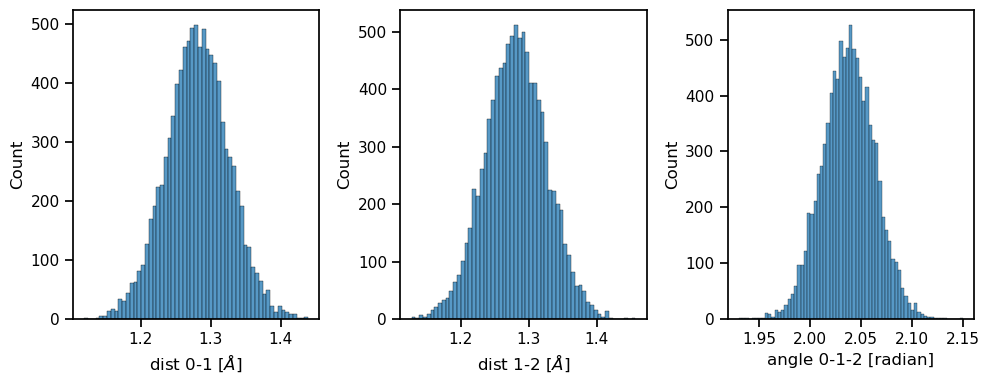

In [7]:
def analyze_configurations():
    # Compute the three degrees of freedom.
    dist_10 = np.empty(10000)
    dist_12 = np.empty(10000)
    angles = np.empty(10000)
    with MDAnalysis.coordinates.DCD.DCDReader(f'{MAIN_DIR}/md/traj.dcd') as trajectory:
        for idx, timestep in enumerate(trajectory):
            positions = timestep.positions
            r10 = positions[0] - positions[1]
            r12 = positions[2] - positions[1]
            dist_10[idx] = np.linalg.norm(r10)
            dist_12[idx] = np.linalg.norm(r12)
            angles[idx] = np.arccos(np.dot(r10/dist_10[idx], r12/dist_12[idx]))

    # Plot the histograms of the three degrees of freedom.
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
    for ax_idx, data in enumerate([dist_10, dist_12, angles]):
        sns.histplot(data, ax=axes[ax_idx])
    axes[0].set_xlabel('dist 0-1 [$\AA$]')
    axes[1].set_xlabel('dist 1-2 [$\AA$]')
    axes[2].set_xlabel('angle 0-1-2 [radian]')
    fig.tight_layout()
    plt.show()

analyze_configurations()

The three DOFs have quite narrow distributions, and if we perturb the equilibrium bond length $r_0$ we can expect the overlap between the reference and pertrubed distributions to decrease quite fast.

In this simple case, it is possible to predict the free energy difference as a function of $r_0$. We can remove the rigid rototranslational contributions by placing atom 1 in the origin, atom 0 on the $x$ axis, and atom 2 on the $x-y$ plane. Then, after converting the coordinates of atom 2 from cartesian to polar, it is easy to show that the free energy difference (in reduced units) of perturbing $r_0 \to r'_0$ is

$$
\Delta f = - \log \frac{\int e^{-K_{r_0}(x - r'_0)^2} \mathrm{d}x \int e^{-K_{r_0}(r - r'_0)^2} r \mathrm{d}r \int e^{-K_{\alpha_0}(\alpha - \alpha_0)^2} cos(\alpha) \mathrm{d}\alpha}{\int e^{-K_{r_0}(x - r_0)^2} \mathrm{d}x \int e^{-K_{r_0}(r - r_0)^2} r \mathrm{d}r \int e^{-K_{\alpha_0}(\alpha - \alpha_0)^2} cos(\alpha) \mathrm{d}\alpha} = -\log \frac{r'_0}{r_0}
$$

## Standard free energy perturbation

We can now check the performance of standard FEP as the perturbation in $r_0$.

In [ ]:
def compute_fep_estimate(target_r0):
    """Standard free energy perturbation.

    Compute the free energy difference between the reference distribution and
    the distribution with equilibrium bond length target_r0.

    Parameters
    ----------
    target_r0 : openmm.unit.Quantity
        The equilibrium bond length of the target potential energy function.

    """
    # First, we need to re-evaluate the potential energy of the configurations
    # sampled with the reference MD simulation using target_r0.
    openmm_context = openmm.Context(
        create_triatomic_molecule(r0=target_r0)[0],
        openmm.openmm.VerletIntegrator(2.0*openmm.unit.femtosecond),
        openmm.Platform.getPlatformByName('CPU'),
    )

    # Compute the target potentials for all configurations.
    target_potentials = []
    with MDAnalysis.coordinates.DCD.DCDReader(f'{MAIN_DIR}/md/traj.dcd') as trajectory:
        for timestep in trajectory:
            # MDAnalysis reads positions in Angstrom but OpenMM accepts nanometers.
            openmm_context.setPositions(timestep.positions / 10)
            state = openmm_context.getState(getEnergy=True)

            # OpenMM return the energies in kJ/mol.
            target_potentials.append(state.getPotentialEnergy()._value)

    # Convert from list to numpy array.
    target_potentials = np.array(target_potentials)

    # Now load the energies sampled with the reference MD.
    steps, reference_potentials = np.loadtxt(f'{MAIN_DIR}/md/energies.csv', delimiter=',').T

    # Compute the free energy difference.
    work = torch.tensor(target_potentials - reference_potentials)
    df = tfep.analysis.fep_estimator(work, kT=RT)

    # The TFEP library has functions to perform (bayesian) bootstrap
    # analysis to get an approximate estimate of the uncertainty.
    fep_estimator = functools.partial(tfep.analysis.fep_estimator, kT=RT)
    bootstrap_analysis = tfep.analysis.bootstrap(work, fep_estimator, n_resamples=2000, bayesian=True)

    df_mean = bootstrap_analysis['mean']
    ci_low = bootstrap_analysis['confidence_interval']['low']
    ci_high = bootstrap_analysis['confidence_interval']['high']
    print(f'Df = {df} ({df_mean}) [{ci_low}, {ci_high}] kJ/mol')

In [ ]:
compute_fep_estimate(target_r0=1.31*openmm.unit.angstroms)
print(f'Correct Df = {-RT*np.log(1.31/1.278)} kJ/mol')

/usr/local/lib/python3.10/dist-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


Df = -0.2860998560439967 (-0.2855375363935697) [-0.3484750311933955, -0.2271823693093556] kJ/mol
Correct Df = -0.06130654404637665 kJ/mol


In [ ]:
compute_fep_estimate(target_r0=1.7*openmm.unit.angstroms)
print(f'Correct Df = {-RT*np.log(1.7/1.278)} kJ/mol')

Df = 109.42345178743534 (110.74018250759458) [106.15834910440587, 117.06674738063921] kJ/mol
Correct Df = -0.7073255071448409 kJ/mol


As expected, the performance of standard FEP decreases very rapidly with the size of the perturbation.

## Targeted free energy perturbation with the `tfep` library

Now we can test TFEP instead. The following two functions implement a single-epoch multimap TFEP calculation as described in [this paper](https://doi.org/10.1073/pnas.2304308120).

In [ ]:
def run_tfep_training(output_dir_path, target_r0=1.278*openmm.unit.angstroms, n_epochs=1):
    """Trains a TFEP map and saves the potential energies evaluated with r0=target_r0.

    Parameters
    ----------
    output_dir_path : str
        Where to save the output files.
    target_r0 : openmm.unit.Quantity
        The equilibrium bond length of the target potential energy function.
    n_epochs : int
        The number of training epochs.

    """
    import tfep.app
    import tfep.potentials.openmm

    # Create TFEP map.
    tfep_map = tfep.app.CartesianMAFMap(
        # Target potential energy function.
        potential_energy_func=tfep.potentials.openmm.OpenMMPotential(
            system=create_triatomic_molecule(r0=target_r0)[0],
            platform='CPU',  # Change this to 'CUDA' to run on the GPU.
            positions_unit=UNITS.angstrom,  # Units of the input positions.
            energy_unit=UNITS.kJ/UNITS.mole,  # Units of the returned energies.
            # Useful for caching the OpenMM Context and avoid re-initializing it at every batch.
            system_name='triatomic',
            precompute_gradient=True,  # Necessary to compute gradients for training.
        ),
        # Data.
        topology_file_path=f'{MAIN_DIR}/md/triatomic.pdb',
        coordinates_file_path=f'{MAIN_DIR}/md/traj.dcd',
        # We don't really need to map the rototranslational degrees of freedom.
        # origin_atom and axes_atoms force the map to place atom 1 in the origin
        # and atoms 0, 2 on the x-y plane and maps only the unconstrained DOFs.
        origin_atom=[1],
        axes_atoms=[0, 2],
        # We need to flag atom 1 as an atom whose coordinates are not changed by
        # the map but affect the transformation of the other DOFs.
        conditioning_atoms=[1],
        # Other options.
        temperature=TEMPERATURE,  # Temperature.
        batch_size=16,  # Batch size.
        tfep_logger_dir_path=f'{output_dir_path}/tfep_logs',  # Where to save the target potential energies.
    )

    # Optimize the map and save the computed target potential energies.
    trainer = lightning.Trainer(
        max_epochs=n_epochs,  # Run for n_epochs.
        default_root_dir=output_dir_path,  # Where to save the Lightning logs.
    )
    trainer.fit(tfep_map)


def compute_single_epoch_mtfep_estimate(dir_path):
    """This function reads the potentials saved during training and compute the Df.

    It performs a bootstrap analysis of the data as a function of the number of
    samples to evaluate the convergence.

    """
    # Read the data from the Read the data from the TFEP logger (DFT potentials).
    tfep_logger_dir_path = f'{dir_path}/tfep_logs'
    tfep_logger = tfep.io.TFEPLogger(tfep_logger_dir_path)

    # This reads the potential energies evaluated during the first epoch of training
    tfep_data = tfep_logger.read_train_tensors(epoch_idx=0)

    # Read the vacuum potentials (saved in kJ/mol).
    steps, reference_potentials = np.loadtxt(f'{MAIN_DIR}/md/energies.csv', delimiter=',').T
    reference_potentials = torch.tensor(reference_potentials)

    # The samples where shuffled during training so we need to match them.
    reference_potentials = reference_potentials[tfep_data['trajectory_sample_index']]

    # Potentials and log_det_Js in the tfep logger are stored in in units of kT
    # while OpenMM saves energies in kJ/mol.
    target_potentials = tfep_data['potential'] * RT
    log_det_J = tfep_data['log_det_J'] * RT

    # Compute the generalized work (in units of kT).
    work = target_potentials - log_det_J - reference_potentials

    # Compute the free energy and work statistics with the whole dataset.
    result = {'df': tfep.analysis.fep_estimator(work, kT=RT)}

    # Run the bootstrap analysis as a function of the number of samples.
    fep_estimator = functools.partial(tfep.analysis.fep_estimator, kT=RT)
    result['bootstrap_sample_size'] = torch.arange(1000, 11000, 1000)
    result['df_bootstrap'] = tfep.analysis.bootstrap(
        data=work,
        statistic=fep_estimator,
        n_resamples=2000,
        bootstrap_sample_size=result['bootstrap_sample_size'],
        take_first_only=True,
        batch=1000,
        bayesian=True,
    )

    return result


In [ ]:
run_tfep_training(output_dir_path=f'{MAIN_DIR}/mtfep', target_r0=1.7*openmm.unit.angstroms, n_epochs=1)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/tfep/nn/flows/oriented.py:139: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:62.)
  plane_normal_vector = torch.cross(axis_vector, plane_axis_vector)
INFO: 
  | Name                   | Type                 | Params | Mode 
------------------------------------------------------------------------
0 | _potential_energy_func | OpenMMPote

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
# Now run the bootstrap analysis.
mtfep_analysis = compute_single_epoch_mtfep_estimate(dir_path=f'{MAIN_DIR}/mtfep')

Now let's plot the free energy trajectory as the calculation progresses.

Df = -0.5592270632276191 (-0.5596894009473848) [-0.5919301921111444, -0.5277030854991921] kJ/mol


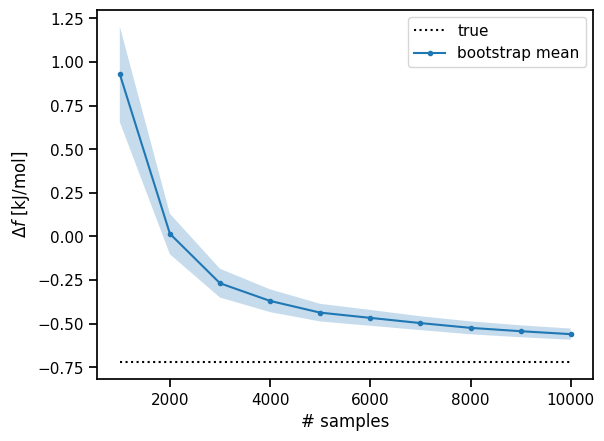

In [ ]:
def plot_free_energy_trajectory(analysis, ref_r0, target_r0):
    # Plot the the free energy trajectory.
    fig, ax = plt.subplots()
    bootstrap_sample_size = analysis['bootstrap_sample_size']

    # Plot true free energy.
    ref_df = - RT* np.log(target_r0 / ref_r0)
    ax.hlines(ref_df, bootstrap_sample_size[0], bootstrap_sample_size[-1], label='true', color='black', linestyle=':')

    # Plot mean bootstrap statistics.
    mean_bootstrap_df = [x['mean'].tolist() for x in analysis['df_bootstrap']]
    ax.plot(bootstrap_sample_size, mean_bootstrap_df, label='bootstrap mean', marker='.')

    # Plot bootstrap confidence interval.
    low_ci = [x['confidence_interval']['low'].tolist() for x in analysis['df_bootstrap']]
    high_ci = [x['confidence_interval']['high'].tolist() for x in analysis['df_bootstrap']]
    ax.fill_between(bootstrap_sample_size, low_ci, high_ci, alpha=0.25)

    ax.set_ylabel('$\Delta f$ [kJ/mol]')
    ax.set_xlabel('# samples')
    ax.legend()

    print(f'Df = {analysis["df"]} ({mean_bootstrap_df[-1]}) [{low_ci[-1]}, {high_ci[-1]}] kJ/mol')

plot_free_energy_trajectory(mtfep_analysis, ref_r0=1.278, target_r0=1.71)